In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA





In [85]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
#  'zPSFFluxErr',
 'zApFlux',
#  'zApFluxErr',
#  'zApFillFac',
#  'zApRadius',
 'zKronFlux',
#  'zKronFluxErr',
 'zKronRad',
#  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
#   'yPSFFluxErr',
  'yApFlux',
#   'yApFluxErr',
#   'yApFillFac',
#  'yApRadius',
 'yKronFlux',
#  'yKronFluxErr',
 'yKronRad',
#  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

lc_and_host_features = feature_names_r_g+feature_names_hostgal

In [92]:
dataset_bank_90k = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,)
                                  #)
        
# drop row if any feature values are nan
dataset_bank_90k = dataset_bank_90k[~dataset_bank_90k[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank_90k.drop_duplicates(subset="ztf_object_id", keep='first', inplace=True)
dataset_bank_90k = dataset_bank_90k.set_index('ztf_object_id')
dataset_bank_90k.index.rename("TransientName", inplace=True)
dataset_bank_90k

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,125,129,130,131,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,anom_score,anomaly_score,anomaly_mask,anomaly_type,is_corrected,vpdf_extreme_version,vpdf_extreme_faint,vpdf_extreme_bright,locus_gal_l,locus_gal_b
TransientName,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.881532,-69.513571
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.200342,-26.246909
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352953
ZTF18aczbnhl,97,ANT2019dsk24,85.049145,-11.013302,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,105,12,ztf_candidate:718232301815010005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.961559,-20.751422
ZTF18actbhqt,98,ANT202066j3s,75.082443,-11.302676,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,89,14,ztf_candidate:702289832715010026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.690974,-29.741520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18adairvu,999924,ANT2020ro626,84.348727,-2.927551,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,96,10,ztf_candidate:722282332515010003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.956641,-17.786773
ZTF20aaiwhct,999926,ANT2020pxghw,64.146691,-1.656598,"['dimmers', 'lc_feature_extractor']","['gaia_dr2', 'bright_guide_star_cat', 'allwise']",NaN,86,35,ztf_candidate:1113204944015010026,...,NaN,NaN,NaN,TBD,NaN,NaN,NaN,NaN,194.540371,-34.719753
ZTF20aberawv,999927,ANT2020aebbk,292.910293,54.078978,"['lc_feature_extractor', 'dimmers']",[],NaN,235,96,ztf_candidate:1231482062015010023,...,NaN,0.417276,Fail,TBD,NaN,NaN,NaN,NaN,85.961850,16.149525


In [129]:
# Instead of above, read in from csv files with host gal info!
# Visually vetted GHOST results split up over XXX files
# So merge them

dfs = []
for start_idx, end_idx in zip(range(0, 25300, 100), range(100, 25400, 100)): #90199, 90299
    df = pd.read_csv(f'./host_info/dataset_bank_hosts_start_idx:end_idx={start_idx}:{end_idx}.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df.drop_duplicates(subset="TransientName", keep='first', inplace=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
#g_hosts_df.reset_index(inplace=True, drop=True)
g_hosts_df

,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
TransientName,,,,,,,,,,,,,,,,,,,,,
AT2019ye,PSO J135804.487+203809.056,NaN,NaN,NaN,132762095186853570,916270000024592,143378893266959,0,14931762990582,13276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2018ajl,PSO J190429.931+465408.150,NaN,NaN,NaN,164282861247243384,980181000018761,286229505526092,0,14030330328091,16428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2018avp,PSO J130026.839+183711.266,NaN,NaN,NaN,130341951118084283,908497000031128,142408230664599,0,15113135908185,13034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2018big,PSO J172538.410+592648.115,NaN,NaN,NaN,179332614100166803,964525000048937,310173948231464,0,14734825883801,17933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2018ccp,PSO J173213.761+360428.339,NaN,NaN,NaN,151292630573220037,966054000051498,221568772917547,0,14375430020535,15129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21abrpphg,PSO J012315.346-020430.584,NaN,NaN,NaN,105510208138990094,923091000058397,363143779902493,0,9019856366630,10551,...,1.0,0.868907,1.93800,1.76842,2.27497,0.787416,NaN,1.0,False,NaN
ZTF21abzbiom,PSO J014950.174-051225.692,NaN,NaN,NaN,101750274590611830,928992000080203,363362823256394,0,8964315401283,10175,...,1.0,2.089700,1.93471,2.04145,1.70214,0.940182,NaN,0.0,False,NaN
ZTF21abzkgvc,PSO J040504.611-015727.759,NaN,NaN,NaN,105650612692451172,955206000000321,365944098521408,0,9456016936636,10565,...,1.0,4.595920,5.12260,4.62076,4.90688,4.652400,NaN,0.0,False,NaN


In [130]:
len(np.unique(g_hosts_df.index))

7652

In [131]:
# merge ghost info and databank info

# rename as dataset_bank
dataset_bank = pd.merge(dataset_bank_90k, g_hosts_df, left_index=True, right_index=True, how='inner')
dataset_bank.index.rename("ztf_object_id", inplace=True)
dataset_bank

,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,1.0,6.10360,4.04109,1.675730,3.49369,29.58050,NaN,0.0,False,NaN
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,1.0,7.05256,1.08888,1.214940,3.95098,1.72927,NaN,0.0,False,NaN
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,1.0,3.99288,1.86034,0.730485,1.92726,1.96452,NaN,0.0,NaN,NaN
ZTF18actbhqt,98,ANT202066j3s,75.082443,-11.302676,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,89,14,ztf_candidate:702289832715010026,...,1.0,NaN,NaN,2.092530,NaN,NaN,NaN,1.0,NaN,NaN
ZTF20aciscxz,100,ANT2020aegc7vi,83.973369,-9.123083,"['lc_feature_extractor', 'high_flux_ratio_wrt_...","['allwise', 'bright_guide_star_cat']",NaN,48,18,ztf_candidate:1356481843915015002,...,1.0,1.05484,1.57786,1.876240,0.98579,1.65329,NaN,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acxfccu,326223,ANT2020afji4oq,191.351767,26.925617,"['desi_target', 'nova_test', 'refitt_newsource...",['2mass_xsc'],NaN,43,21,ztf_candidate:1441508173415015002,...,1.0,6.01739,5.81578,6.103540,5.79434,5.62845,NaN,1.0,False,NaN
ZTF20acpjcoe,326232,ANT2020aexbg6a,330.256572,-1.151345,"['high_flux_ratio_wrt_nn', 'nuclear_transient'...","['bright_guide_star_cat', 'sdss_gals']",NaN,53,33,ztf_candidate:1410128004515015003,...,1.0,2.65810,2.58869,2.343160,-2.41460,2.89477,NaN,0.0,False,NaN
ZTF18acpivjt,326255,ANT2020rrroe,168.085849,60.629421,"['siena_mag_coord_cut', 'lc_feature_extractor']",[],NaN,85,8,ztf_candidate:686448812215015114,...,1.0,1.96559,2.27053,2.308530,NaN,2.47489,NaN,0.0,NaN,NaN


In [132]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features] #dataset_bank[feature_names_r_g]
# drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]

dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,2.61862,4.821850,0.133400,-0.122499,-0.208099,-0.147800,-0.076401,-0.254801,66.227214,3.921571
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,2.22918,1.668850,0.746799,-0.022400,-0.078699,-0.078100,-0.126400,-0.128500,10.879219,4.737505
ZTF20aciscxz,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,-0.871550,0.001117,...,2.04419,0.370268,0.239000,-0.117100,-0.058001,-0.122601,-0.058800,-0.289900,31.205722,0.113062
ZTF18abdkosj,1.776150,-0.175299,0.200000,0.000000,0.353906,3.552299,3.552299,1.268549,2.222622,0.005808,...,7.00214,34.046101,0.083700,0.687300,0.689600,0.746500,0.728600,0.830700,15.107083,4.124426
ZTF18abrcoty,0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,0.004197,...,8.49324,25.945101,0.101501,1.296299,1.073200,1.217402,1.265799,1.170100,20.028593,0.130795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18aaqujbu,0.782113,-0.787636,0.250000,0.000000,0.357005,1.564226,1.564226,1.033506,1.071701,-0.000771,...,2.56129,0.072383,0.283600,-0.146400,-0.021099,-0.135199,-0.031099,-0.087000,120.801682,2.383159
ZTF20acxfccu,0.369985,-0.210291,0.333333,0.000000,0.418449,0.739969,0.700308,0.511403,-1.046592,0.015968,...,7.76271,28.694201,0.172899,0.870899,1.020100,0.990299,0.916300,0.777100,99.725303,0.347883
ZTF20acpjcoe,1.110643,0.194630,0.142857,0.267261,0.364282,2.221287,1.381418,0.596590,2.009210,-0.003174,...,2.87378,7.623930,0.061300,-0.043600,-0.005100,0.001801,0.027700,-0.034901,24.803882,0.154291


In [133]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar
#scaler = preprocessing.MaxAbsScaler() # Create a scalar
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.18878132 0.32430551 0.43207877 0.50179375 0.5651873  0.61183164
 0.64406545 0.66741321 0.69038313 0.71151866 0.72988819 0.74757133
 0.76361109 0.77745722 0.79045885 0.80249451 0.81434546 0.8246542
 0.83473753 0.84420741 0.85355806 0.86230905 0.87077453 0.87859878
 0.8858066 ]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [134]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,-0.740876,0.327463,0.093585,0.530449,-0.256234,0.232915,-0.623253,-0.166695,-0.236554,-0.307001,...,-0.162461,-0.099282,0.076956,0.061536,0.118566,-0.165056,-0.118792,0.011117,0.241731,-0.134966
ZTF18acfvwwa,-1.009465,0.483343,-0.091841,-0.047224,0.308276,0.266342,-0.270570,-0.157739,-0.166764,-0.307726,...,-0.026842,0.162825,-0.003783,0.232018,-0.141472,-0.160099,-0.101088,0.241140,0.017308,-0.038038
ZTF20aciscxz,-0.017361,-0.685588,-0.670049,0.157348,0.226343,0.100455,0.115739,-0.119346,0.435864,0.337444,...,0.106838,0.033598,-0.044141,0.292700,0.045342,-0.069082,-0.170820,-0.045557,-0.003166,0.189726
ZTF18abdkosj,-0.061421,1.320940,0.550628,-0.211640,-1.040916,-0.143873,0.427948,0.501807,-0.059357,0.231840,...,-0.183969,0.259620,-0.251668,0.291740,0.070171,0.034689,-0.060737,-0.058413,-0.316372,-0.006297
ZTF18abrcoty,0.770735,-0.645791,0.341429,-0.421324,-0.814975,-0.329319,0.094102,-0.627922,-0.136354,0.194735,...,-0.328912,-0.288205,-0.194450,0.099696,0.132917,0.073406,-0.283018,0.272803,-0.097284,-0.060154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18aaqujbu,0.284788,1.003430,-0.985703,-0.320762,-0.044550,0.252116,-0.030890,-0.577123,-0.179849,-0.060159,...,0.110075,-0.274038,-0.209469,-0.109640,-0.113971,0.237414,0.015706,-0.068186,0.044968,0.061490
ZTF20acxfccu,1.163744,0.057910,0.751615,0.076237,0.537662,0.129579,0.386170,0.326000,-0.072738,-0.206703,...,-0.052167,-0.016208,0.213481,-0.118850,0.024957,0.132453,-0.044554,-0.074160,0.020471,0.067533
ZTF20acpjcoe,0.224535,0.566490,0.242256,0.775567,0.326212,0.853905,-0.173623,-0.263680,-0.274480,0.035241,...,-0.165939,-0.069985,0.157781,0.103398,-0.061902,0.081462,-0.148421,0.034548,0.092817,-0.123910


In [204]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()

# for Lc + host features
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aciwhcb'] # Ia
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpdyyq'] # star - weird that it has host info (CHECK INTO THIS)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuyayk'] # RRyl kinda star behavior 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvmlow'] # close SN (curious if host is HII region or actual host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvbbvs'] # variable - check host info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20actvmqi'] #SN Ia w/ small ANN=1 dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpjcoe'] # SN Ia, z=0.04
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadoota'] # IIn, z=0.058
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abywydb'] #II, z=0.04 no apparent host
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwobku'] #2020acct (matches to a couple IIb)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabxjqr'] # IIb, z=0.03
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19ackwoak'] # star (check host) (finds other stars)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvlumw'] # central bogus obs in bright gal core (check host) (finds more bogus)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aacoati'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagtqna'] # long lived IIP, closeby (finds more IIs)
dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acrjydf'] #CV/nova in M31 (check host in GHOST)

# for host features only
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18acrjydf,0.210314,1.046649,-0.262731,-0.063274,-0.148707,0.934065,1.03712,-0.101492,0.142617,-0.170727,...,0.182007,-0.113389,-0.196484,-0.360507,0.301896,-0.024859,0.057112,0.076414,0.005037,-0.185554


In [205]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = display_markdown(f'https://alerce.online/object/{ztf_id}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

ZTF ID name (ref) ZTF18acrjydf


https://alerce.online/object/ZTF18acrjydf

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF18acrjydf

0		1133				None			0.0


https://alerce.online/object/ZTF18abnxdlr

1		657				None			1.0837


https://alerce.online/object/ZTF19aaortys

2		4953				None			1.2855


https://alerce.online/object/ZTF18accqoid

3		4317				None			1.294


https://alerce.online/object/ZTF17aadhojj

4		3524				None			1.3946


https://alerce.online/object/ZTF19aaawcck

5		4717				None			1.4024


https://alerce.online/object/ZTF18acfvdps

6		3111				None			1.4093


https://alerce.online/object/ZTF19abxpoxx

7		3212				None			1.4148


https://alerce.online/object/ZTF18abbalsj

8		1047				None			1.433


https://alerce.online/object/ZTF18adbmjun

9		5436				None			1.4341


In [179]:
results_df = dataset_bank[dataset_bank.index.isin(idx_arr[result_id])]
results_df = results_df.reindex(idx_arr[result_id])
results_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpjcoe,0.224535,0.566490,0.242256,0.775567,0.326212,0.853905,-0.173623,-0.263680,-0.274480,0.035241,...,-0.165939,-0.069985,0.157781,0.103398,-0.061902,0.081462,-0.148421,0.034548,0.092817,-0.123910
ZTF21aaphlty,0.406718,0.588532,0.227268,0.445513,0.738978,0.721315,-0.035245,-0.315780,-0.064052,-0.100828,...,-0.183692,-0.186780,0.200088,-0.072723,0.052464,-0.126119,0.122489,-0.084576,-0.067653,0.011282
ZTF20abvowvw,0.067413,0.776745,-0.001059,0.515824,0.612684,0.708358,0.298317,-0.184456,-0.127795,0.238591,...,-0.083730,-0.124317,0.170197,-0.006322,0.023984,-0.187800,0.064759,-0.063446,0.021706,-0.147334
ZTF19aadoota,-0.056919,0.196331,0.191289,0.412090,0.444049,0.719631,-0.065765,-0.284738,-0.034154,0.134905,...,-0.051208,-0.099738,-0.058770,-0.246198,-0.012071,-0.015647,-0.009683,0.003243,-0.014203,0.053404
ZTF19aaluacc,0.372949,0.223254,0.184414,0.679922,0.420685,0.789952,0.205168,-0.288276,-0.044720,-0.287261,...,-0.196574,-0.112468,0.032500,-0.072035,-0.177958,-0.287701,0.010352,-0.255483,0.090885,0.034967
ZTF20abywydb,0.428686,0.307549,0.493391,0.279515,0.560400,0.522277,0.071725,-0.262748,-0.029899,0.054425,...,-0.193148,0.007863,0.140674,-0.112031,0.095084,-0.061999,-0.128462,-0.225592,-0.127762,-0.120298
ZTF21aamiukc,0.258648,0.385504,0.110195,0.414644,0.587817,0.759155,0.319276,-0.187737,0.086711,-0.246093,...,-0.142547,-0.118671,-0.054412,-0.199626,-0.152480,-0.107907,-0.081791,-0.064342,0.045053,-0.015065
ZTF20acggxac,0.157185,0.036184,0.344125,0.407427,0.249108,0.807223,-0.211627,-0.207803,-0.002088,0.143276,...,-0.261472,0.050268,0.017663,-0.100755,0.025363,0.272668,0.011465,0.132192,-0.126066,0.154299
ZTF20acvezvs,-0.088187,-0.069083,0.019650,0.549539,0.548172,0.901192,-0.047968,-0.320738,-0.016380,0.237838,...,-0.050727,0.067044,0.288041,0.009743,0.094507,0.104020,0.070973,-0.080306,0.096016,0.017690


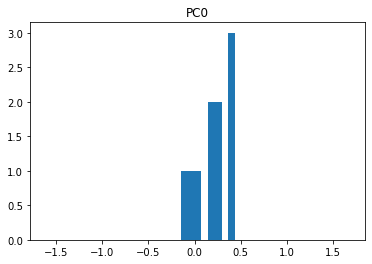

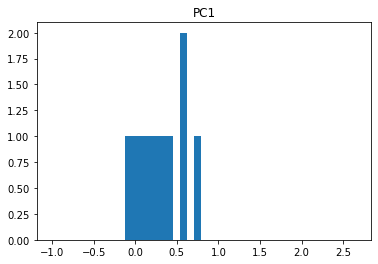

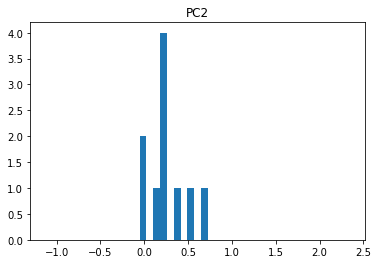

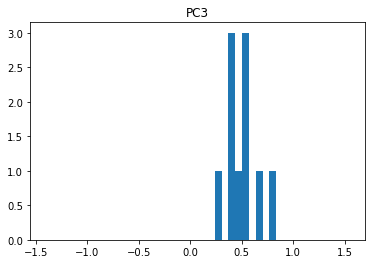

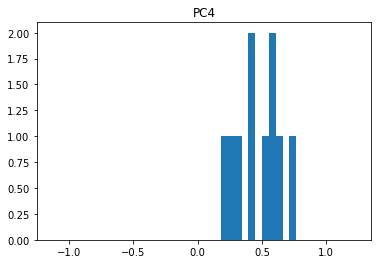

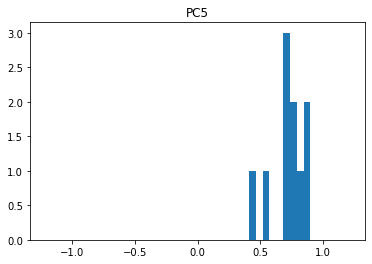

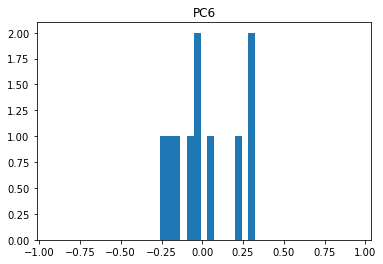

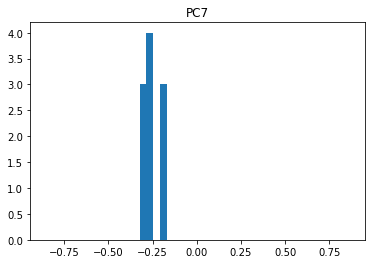

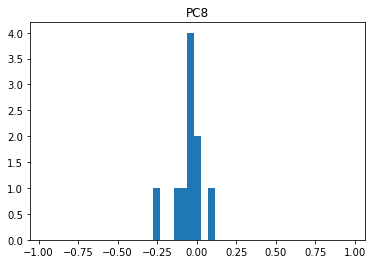

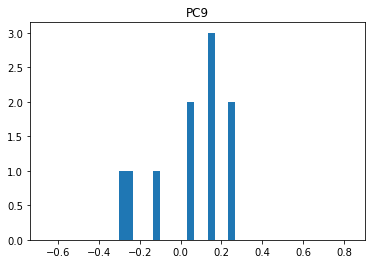

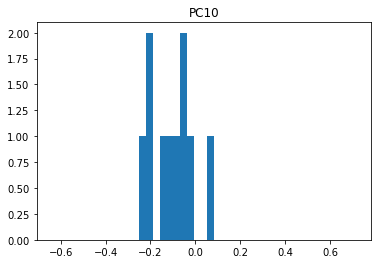

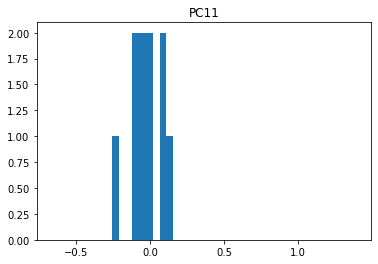

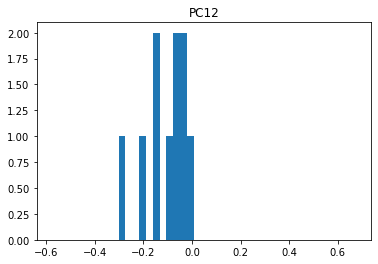

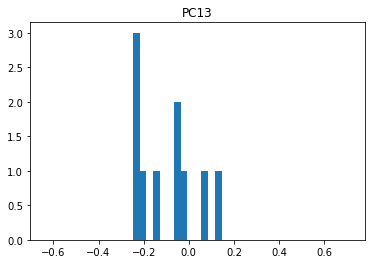

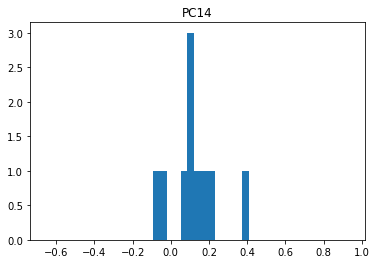

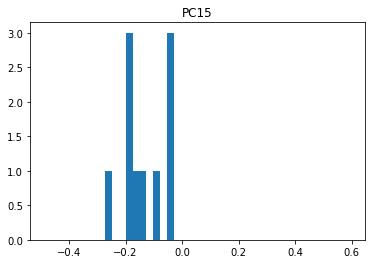

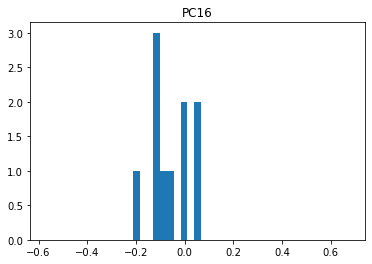

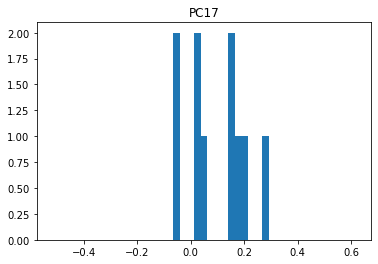

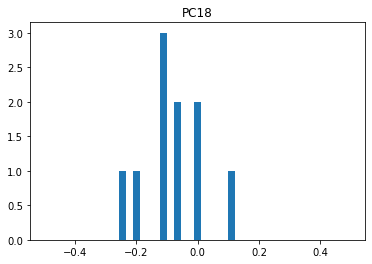

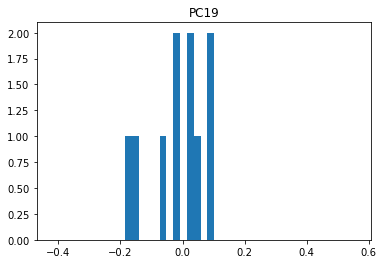

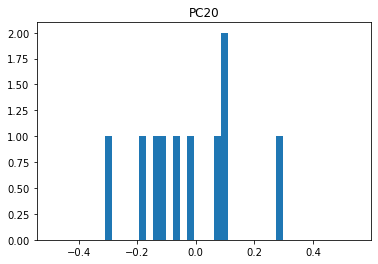

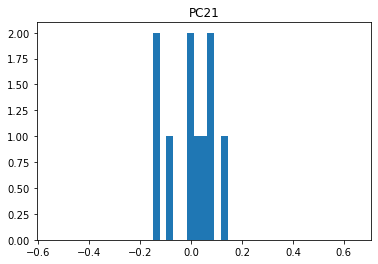

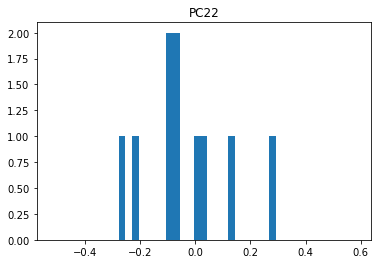

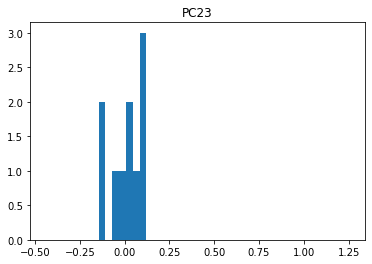

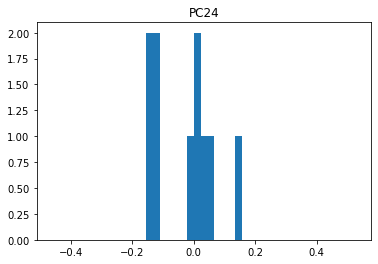

In [180]:
feat_scatter_l = []
for feat in results_df.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(results_df[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(results_df[feat])
    feat_scatter_l.append(feat_scatter)    

In [181]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.12426773682292841
Scatter median: 0.1087977693381017
Scatter std: 0.04906726674442312
Scatter max: 0.2573677265060483
Scatter min: 0.04683367486501401


In [182]:
list(np.unique(dataset_bank.index))

['ZTF17aaaceht',
 'ZTF17aaadqdy',
 'ZTF17aaadqyf',
 'ZTF17aaadvbq',
 'ZTF17aaaeqwm',
 'ZTF17aaaessf',
 'ZTF17aaaeszu',
 'ZTF17aaafvwp',
 'ZTF17aaaiujz',
 'ZTF17aaajigm',
 'ZTF17aaaosws',
 'ZTF17aaaszpi',
 'ZTF17aaawfja',
 'ZTF17aaaxbpe',
 'ZTF17aaaxepf',
 'ZTF17aaaylgr',
 'ZTF17aaaylji',
 'ZTF17aaayqxe',
 'ZTF17aaazdba',
 'ZTF17aaazswp',
 'ZTF17aabatnf',
 'ZTF17aabayoe',
 'ZTF17aabbekc',
 'ZTF17aabbyml',
 'ZTF17aabcdvi',
 'ZTF17aabfalr',
 'ZTF17aabfisy',
 'ZTF17aabrisn',
 'ZTF17aabtjot',
 'ZTF17aabvadg',
 'ZTF17aabvbro',
 'ZTF17aabvbxh',
 'ZTF17aabvdvz',
 'ZTF17aabvgff',
 'ZTF17aabvhms',
 'ZTF17aabvsex',
 'ZTF17aabvslj',
 'ZTF17aabwfng',
 'ZTF17aabwial',
 'ZTF17aabwnil',
 'ZTF17aabyjvg',
 'ZTF17aacdedh',
 'ZTF17aacerqo',
 'ZTF17aacgbkd',
 'ZTF17aacgbnb',
 'ZTF17aacovpb',
 'ZTF17aacqbsh',
 'ZTF17aacrdcz',
 'ZTF17aacsrdl',
 'ZTF17aacwthb',
 'ZTF17aacwvlz',
 'ZTF17aacxlmj',
 'ZTF17aacxngg',
 'ZTF17aacxqcb',
 'ZTF17aadcxky',
 'ZTF17aadecfa',
 'ZTF17aadgjxx',
 'ZTF17aadhojj',
 'ZTF17aadijjx

In [183]:
%%time

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index))[0:10000]:
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, 10)]
# sum specific columns
ann_dist_all_df[f'Mean_{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))

# weighted distance of first 9 ANNs
weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
ann_dist_all_df[f'WeightedMean_{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df

CPU times: user 4.79 s, sys: 105 ms, total: 4.9 s
Wall time: 5 s


,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9,Mean_9ANNs,WeightedMean_9ANNs
key_0,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaceht,2367,241,2346,5456,4957,2659,534,3540,5019,3917,...,0.996831,1.000567,1.022764,1.037713,1.056064,1.056234,1.057521,1.059003,1.022167,0.974364
ZTF17aaadqdy,4793,818,2561,3678,5129,4193,1125,4404,1404,5442,...,0.966972,1.039653,1.062896,1.082271,1.112104,1.118097,1.120462,1.124447,1.064389,0.999342
ZTF17aaadqyf,819,1219,3895,4508,1082,2379,4094,3248,324,921,...,0.776775,0.950473,0.961202,0.963167,0.990270,0.990302,1.022079,1.056498,0.937436,0.828333
ZTF17aaadvbq,818,4793,5508,4425,5129,1154,4015,4404,226,504,...,0.958881,0.969016,0.988413,0.989635,1.001441,1.035004,1.059868,1.070791,1.002849,0.967982
ZTF17aaaeqwm,3977,4266,5348,809,2364,4068,1405,5313,817,1030,...,1.083866,1.143607,1.144229,1.163700,1.181839,1.191178,1.217174,1.272430,1.163876,1.109447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21abrpphg,5396,4417,4003,2660,4334,4034,5335,4010,74,2907,...,0.706000,0.707625,0.721057,0.731263,0.740092,0.753212,0.761812,0.764370,0.730740,0.706871
ZTF21abzbiom,5411,4823,1453,3846,2782,1979,3008,1470,689,403,...,0.840607,0.852942,0.898447,0.905074,0.913475,0.942050,0.946891,0.971400,0.899590,0.852967
ZTF21abzkgvc,5418,4033,4721,3786,121,731,1502,639,4963,2998,...,0.760228,0.760887,0.764045,0.771010,0.793535,0.807325,0.816460,0.831817,0.784464,0.762872


In [184]:
# Pick distance metric. 
# Weighted mean of first 9 ANNs (Fibonacci), OR Mean of first 9 ANNs, OR distance to first ANN. 
# TODO: EXPLORE DIFFERENT METRICS!
dist_col = f'WeightedMean_{len(col_list)}ANNs'  # f'Mean_{len(col_list)}ANNs' # 'dist=1'

print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of mean distance of 9 ANNs
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.8194198384036919
Scatter median: 0.8093058026649735
Scatter std: 0.15645165233397254
Scatter max: 2.1790918572382494
Scatter min: 0.44726135751063173


Most anomalous: ZTF18abvbbvs


# Largest distance


### either bogus (bright "obs" at core which aren't real)
### intense variable star
### bright/ nearby SN
### some truly weird ones (20acct)

In [185]:
ref_obj = ann_dist_all_df[[dist_col]].idxmax().values[0] #'ZTF18acbwaxk'
print("Max dist", ann_dist_all_df.loc[ref_obj][dist_col]) 

Max dist 2.1790918572382494


In [186]:
dataset_bank[dataset_bank.index == ref_obj]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abvbbvs,-0.101891,2.836767,0.208917,0.198537,0.837816,0.561171,0.62694,0.233525,-0.012496,0.104879,...,-0.041475,0.04954,-0.002979,0.298856,0.215709,0.197964,0.42767,-0.325915,0.132709,-0.05478


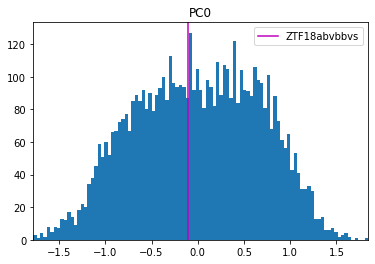

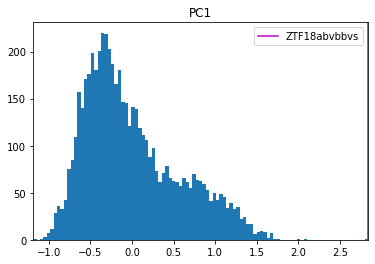

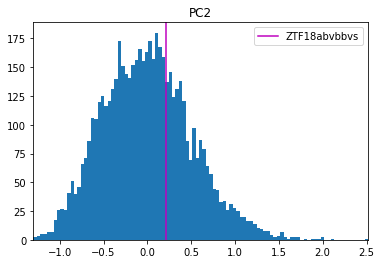

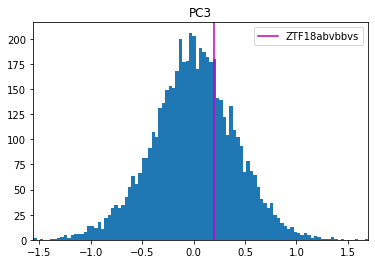

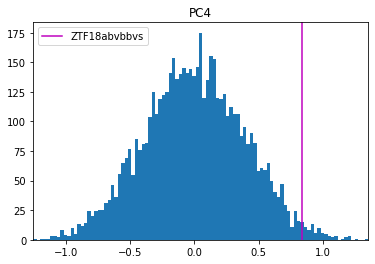

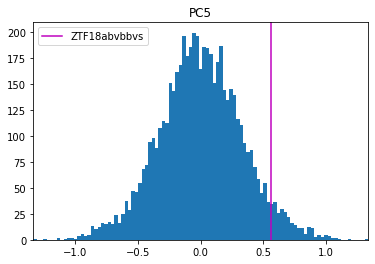

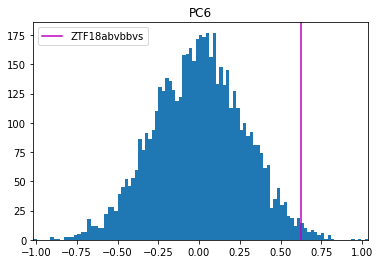

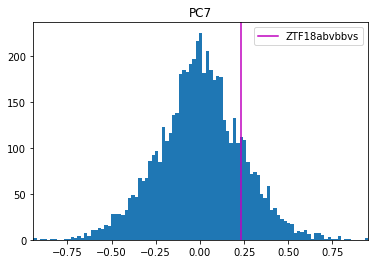

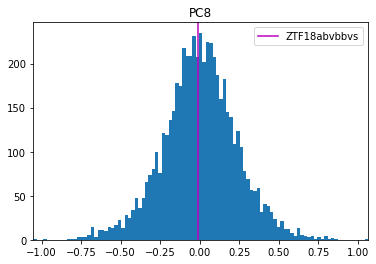

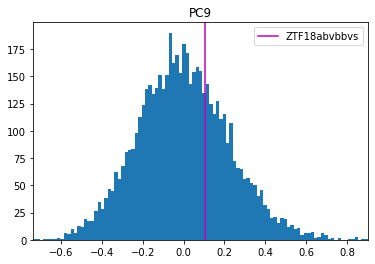

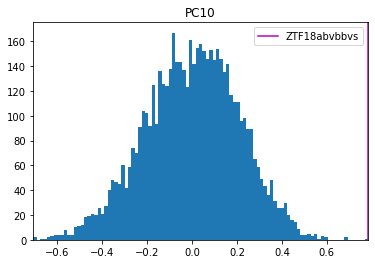

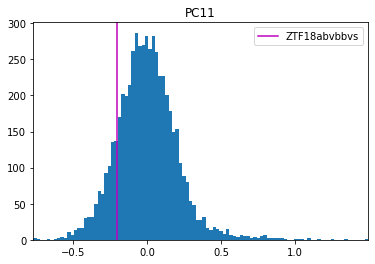

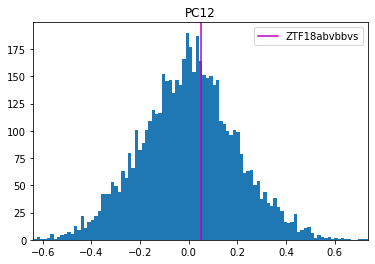

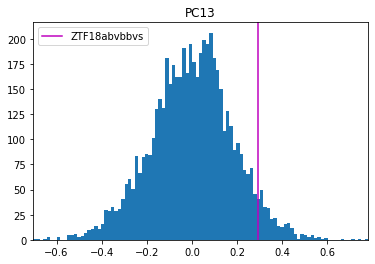

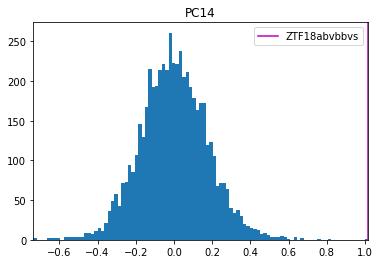

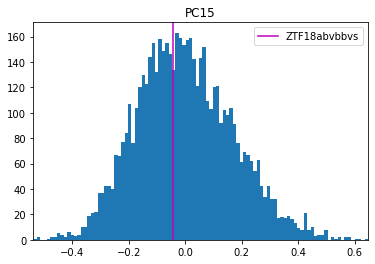

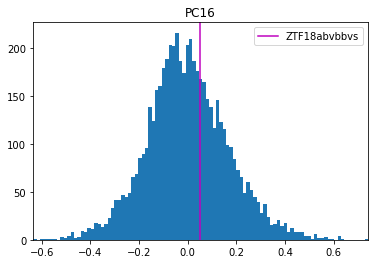

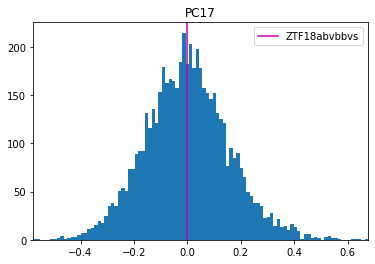

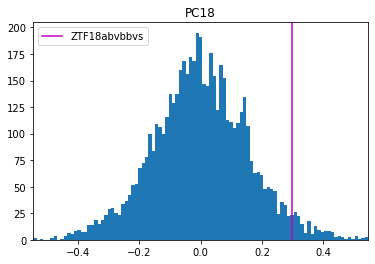

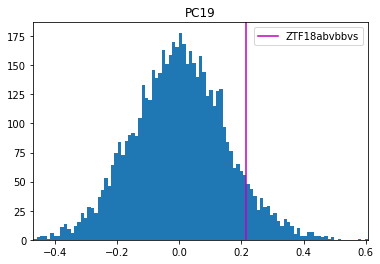

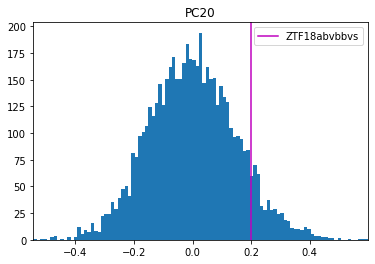

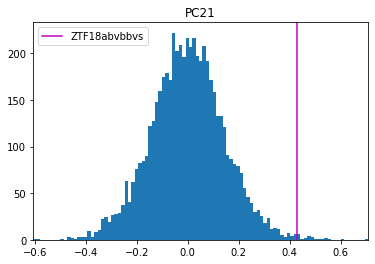

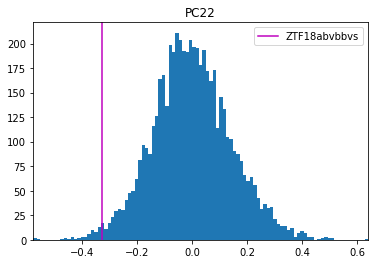

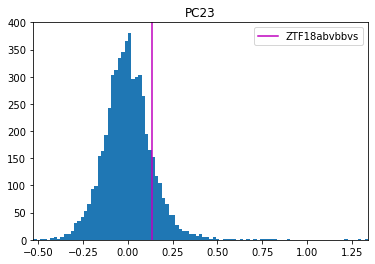

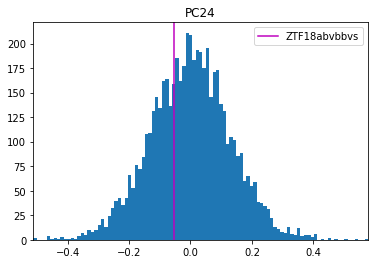

In [187]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [188]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[-0.10189086003048947 2.8367665102071293 0.20891734218923289
 0.19853678733285274 0.8378158168738749 0.5611713798562651
 0.6269399822228056 0.2335249142190573 -0.012495526019412345
 0.10487874032056377 0.7843094524172025 -0.19936315764140033
 0.04966623484389735 0.2934770716224626 1.0161377826979523
 -0.041475333559153456 0.04953991500764785 -0.0029790786640673176
 0.29885575369508144 0.2157091377483472 0.1979638919032499
 0.4276701353828153 -0.3259146001446067 0.13270936579763382
 -0.05477965768269626]
ZTF ID name (ref) ZTF18abvbbvs


https://alerce.online/object/ZTF18abvbbvs

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF18abvbbvs

0		5472				None			0.0


https://alerce.online/object/ZTF20acxzqyp

1		1798				None			2.0983


https://alerce.online/object/ZTF20actawpa

2		1667				None			2.1585


https://alerce.online/object/ZTF17aaazdba

3		5183				None			2.2556


https://alerce.online/object/ZTF18achnuzm

4		1373				None			2.272


https://alerce.online/object/ZTF18abnznca

5		1281				None			2.2761


https://alerce.online/object/ZTF20acjpvyd

6		3313				None			2.2974


https://alerce.online/object/ZTF18aavsboy

7		5306				None			2.3245


https://alerce.online/object/ZTF20acqucpz

8		1830				None			2.3338


https://alerce.online/object/ZTF18acsovsw

9		1138				None			2.334


In [189]:
ann_dist_all_df.loc[ref_obj]

ann=0                 5472.000000
ann=1                 1798.000000
ann=2                 1667.000000
ann=3                 5183.000000
ann=4                 1373.000000
ann=5                 1281.000000
ann=6                 3313.000000
ann=7                 5306.000000
ann=8                 1830.000000
ann=9                 1138.000000
dist=0                   0.000000
dist=1                   2.098318
dist=2                   2.158521
dist=3                   2.255602
dist=4                   2.271993
dist=5                   2.276087
dist=6                   2.297429
dist=7                   2.324497
dist=8                   2.333823
dist=9                   2.334013
Mean_9ANNs               2.261143
WeightedMean_9ANNs       2.179092
Name: ZTF18abvbbvs, dtype: float64

In [190]:
# 10 largest distances
ann_dist_all_df[dist_col].nlargest(100)

key_0
ZTF18abvbbvs    2.179092
ZTF19aaeyltm    1.954658
ZTF18aabjliz    1.903706
ZTF21aaaodzf    1.852180
ZTF18abvmlow    1.704556
                  ...   
ZTF18abynxzs    1.211909
ZTF21aasfdps    1.210211
ZTF18adbcnfi    1.209497
ZTF20aaudvyx    1.208283
ZTF18abiebxx    1.208180
Name: WeightedMean_9ANNs, Length: 100, dtype: float64

In [191]:
# 10 largest distances objs 
for ztfid in list(ann_dist_all_df[dist_col].nlargest(100).index):
    alerce_link = display_markdown(f'https://alerce.online/object/{ztfid}', raw=True)
    print(alerce_link)

https://alerce.online/object/ZTF18abvbbvs

None


https://alerce.online/object/ZTF19aaeyltm

None


https://alerce.online/object/ZTF18aabjliz

None


https://alerce.online/object/ZTF21aaaodzf

None


https://alerce.online/object/ZTF18abvmlow

None


https://alerce.online/object/ZTF18aaqvatw

None


https://alerce.online/object/ZTF20abfehpe

None


https://alerce.online/object/ZTF18abwxrhi

None


https://alerce.online/object/ZTF18acjfdlx

None


https://alerce.online/object/ZTF20ablygyy

None


https://alerce.online/object/ZTF20abxyajd

None


https://alerce.online/object/ZTF21aahpzqi

None


https://alerce.online/object/ZTF20acqucpz

None


https://alerce.online/object/ZTF18aaimlad

None


https://alerce.online/object/ZTF18acslknd

None


https://alerce.online/object/ZTF21aajxkfu

None


https://alerce.online/object/ZTF18abxepqq

None


https://alerce.online/object/ZTF20aammgir

None


https://alerce.online/object/ZTF20acbeokd

None


https://alerce.online/object/ZTF18aapdhva

None


https://alerce.online/object/ZTF19aalwbnj

None


https://alerce.online/object/ZTF20adadrhw

None


https://alerce.online/object/ZTF18abyquqo

None


https://alerce.online/object/ZTF18achruvb

None


https://alerce.online/object/ZTF19abpassc

None


https://alerce.online/object/ZTF20acwobku

None


https://alerce.online/object/ZTF18abvlumw

None


https://alerce.online/object/ZTF18abvdnfx

None


https://alerce.online/object/ZTF20aczgvrr

None


https://alerce.online/object/ZTF19ackwoak

None


https://alerce.online/object/ZTF19acxfjcy

None


https://alerce.online/object/ZTF19aabymti

None


https://alerce.online/object/ZTF19acvuann

None


https://alerce.online/object/ZTF19aastxmm

None


https://alerce.online/object/ZTF19aaczlfy

None


https://alerce.online/object/ZTF18abosrdl

None


https://alerce.online/object/ZTF18aacoati

None


https://alerce.online/object/ZTF18aanlksp

None


https://alerce.online/object/ZTF18abolvsx

None


https://alerce.online/object/ZTF20acohmzr

None


https://alerce.online/object/ZTF19acekpoy

None


https://alerce.online/object/ZTF18actuhrs

None


https://alerce.online/object/ZTF18actaimp

None


https://alerce.online/object/ZTF18acdpool

None


https://alerce.online/object/ZTF21aatqpqa

None


https://alerce.online/object/ZTF19abnpcuc

None


https://alerce.online/object/ZTF21aapzgos

None


https://alerce.online/object/ZTF19abfitee

None


https://alerce.online/object/ZTF18abgyujv

None


https://alerce.online/object/ZTF19aamoiui

None


https://alerce.online/object/ZTF20acwwsiv

None


https://alerce.online/object/ZTF18abcrjaj

None


https://alerce.online/object/ZTF19aamfxft

None


https://alerce.online/object/ZTF18abmjprg

None


https://alerce.online/object/ZTF21aaabvrz

None


https://alerce.online/object/ZTF20acwezdy

None


https://alerce.online/object/ZTF19aakltkm

None


https://alerce.online/object/ZTF18adaivlw

None


https://alerce.online/object/ZTF20abyosmd

None


https://alerce.online/object/ZTF18aajcvol

None


https://alerce.online/object/ZTF18acujsfl

None


https://alerce.online/object/ZTF21aaqwfad

None


https://alerce.online/object/ZTF18aarcfoj

None


https://alerce.online/object/ZTF21aagtqna

None


https://alerce.online/object/ZTF18acszayr

None


https://alerce.online/object/ZTF18aamzgzi

None


https://alerce.online/object/ZTF17aaazdba

None


https://alerce.online/object/ZTF20acohgvg

None


https://alerce.online/object/ZTF18abnzlaf

None


https://alerce.online/object/ZTF17aabvsex

None


https://alerce.online/object/ZTF18abuyayk

None


https://alerce.online/object/ZTF18aakroxr

None


https://alerce.online/object/ZTF18acrjydf

None


https://alerce.online/object/ZTF19aadgjvv

None


https://alerce.online/object/ZTF20acpbbqf

None


https://alerce.online/object/ZTF18abkbyfj

None


https://alerce.online/object/ZTF17aadijjx

None


https://alerce.online/object/ZTF18acsxvso

None


https://alerce.online/object/ZTF18adianie

None


https://alerce.online/object/ZTF18accnimo

None


https://alerce.online/object/ZTF20abjonjs

None


https://alerce.online/object/ZTF18abuvvvi

None


https://alerce.online/object/ZTF18abidsia

None


https://alerce.online/object/ZTF20acfvqjl

None


https://alerce.online/object/ZTF18acauaah

None


https://alerce.online/object/ZTF18acgipnc

None


https://alerce.online/object/ZTF20aabbyef

None


https://alerce.online/object/ZTF18aaqdozs

None


https://alerce.online/object/ZTF21abdrzvg

None


https://alerce.online/object/ZTF21aaaollj

None


https://alerce.online/object/ZTF18abdkosj

None


https://alerce.online/object/ZTF21aabgpfy

None


https://alerce.online/object/ZTF19aanjvpi

None


https://alerce.online/object/ZTF18abtxonb

None


https://alerce.online/object/ZTF18acbvnfp

None


https://alerce.online/object/ZTF18abynxzs

None


https://alerce.online/object/ZTF21aasfdps

None


https://alerce.online/object/ZTF18adbcnfi

None


https://alerce.online/object/ZTF20aaudvyx

None


https://alerce.online/object/ZTF18abiebxx

None


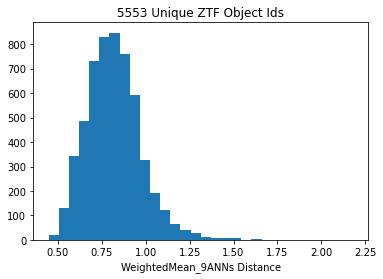

In [192]:
# 10 largest mean 9 ANN distances distances (most different)
plt.hist(ann_dist_all_df[dist_col], 
         bins=np.linspace(np.min(ann_dist_all_df[dist_col]), 
                          np.max(ann_dist_all_df[dist_col]), 31), density=False);
plt.xlabel(dist_col+' Distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');

In [193]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of distance
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.8194198384036919
Scatter median: 0.8093058026649735
Scatter std: 0.15645165233397254
Scatter max: 2.1790918572382494
Scatter min: 0.44726135751063173


Most anomalous: ZTF18abvbbvs


# Smallest

### AGN/QSOs have smallest dist

In [156]:
ann_dist_all_df[dist_col].nsmallest(10)

key_0
ZTF18aaxsntq    0.447261
ZTF20abgtxja    0.464481
ZTF20ablklbb    0.477008
ZTF20actvmqi    0.483384
ZTF20aavxwwm    0.487119
ZTF19acihiav    0.489048
ZTF20aaozxfk    0.492042
ZTF18aafkisa    0.493099
ZTF19acthktz    0.493422
ZTF19aaapksi    0.495531
Name: WeightedMean_9ANNs, dtype: float64

In [157]:
# 10 smallest  distances (most similar)
for ztfid in list(ann_dist_all_df[dist_col].nsmallest(10).index):
    alerce_link = display_markdown(f'https://alerce.online/object/{ztfid}', raw=True)
    print(alerce_link)

https://alerce.online/object/ZTF18aaxsntq

None


https://alerce.online/object/ZTF20abgtxja

None


https://alerce.online/object/ZTF20ablklbb

None


https://alerce.online/object/ZTF20actvmqi

None


https://alerce.online/object/ZTF20aavxwwm

None


https://alerce.online/object/ZTF19acihiav

None


https://alerce.online/object/ZTF20aaozxfk

None


https://alerce.online/object/ZTF18aafkisa

None


https://alerce.online/object/ZTF19acthktz

None


https://alerce.online/object/ZTF19aaapksi

None


In [158]:
dataset_ref = dataset_bank[dataset_bank.index == list(ann_dist_all_df[dist_col].nsmallest(10).index)[0]]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[-0.28191099449885043 0.1997781528483442 0.3301173049244767
 -0.03589630535302615 0.8530689595363097 -0.06568300323676796
 0.23802059745752255 0.0455919105565597 -0.07871161793944403
 0.5377488211670385 -0.14115895686208588 -0.2807128826390712
 0.05874433335528011 -0.05599270086406793 -0.034948406078795013
 0.1572489016317714 0.01436131870810548 0.0818222600177367
 0.026601489725767632 0.15949566700305534 -0.0524796421878041
 0.06316953291367658 -0.006280134941097688 -0.1546435988568619
 -0.03533373014706932]
ZTF ID name (ref) ZTF18aaxsntq


https://alerce.online/object/ZTF18aaxsntq

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF18aaxsntq

0		4421				None			0.0


https://alerce.online/object/ZTF18acbzwmk

1		737				None			0.3513


https://alerce.online/object/ZTF19abegsmi

2		1474				None			0.4204


https://alerce.online/object/ZTF19aalfali

3		2793				None			0.4894


https://alerce.online/object/ZTF19acokqnb

4		4196				None			0.5367


https://alerce.online/object/ZTF20aadxsro

5		478				None			0.6501


https://alerce.online/object/ZTF19abjaeae

6		4512				None			0.6593


https://alerce.online/object/ZTF19abhendr

7		507				None			0.6675


https://alerce.online/object/ZTF18abuoilc

8		2577				None			0.6825


https://alerce.online/object/ZTF18aaudlsu

9		576				None			0.6839


In [28]:
# dist ANN=1 and mean of first 9 ANN are roughly same (SN, CV, Mira, etc). 
# Not as many SN (but otherwise similar as above) in weighted (fibonacci) average of first 9 ANN.
# Separation will come down to host gal info

MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787